In [1]:
import logging
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
%load_ext autoreload

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

2024-03-01 17:31:51,236 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-03-01 17:31:51,237 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2024-03-01 17:31:52.032516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 17:31:53.581227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load Data

In [3]:
# experiment specific
# result_base_dir = "offline1FDR_BBM_647_P241_02_07_ssDDA_MIA_001_ScanByScan_RTtol1.0_threshold_missabthres0.5_convergence_NoIntercept_pred_PScosDist"
result_base_dir = "collinear_BBM_647_P241_02_07_ssDDA_MIA_001_ScanByScan_RTtol1.0_threshold_missabthres0.5_convergence_NoIntercept_pred_PScosDist"

In [4]:
# edit experiment specific data path and config
import json

result_parent_dir = "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/"
MS1Scans_NoArray_path = (
    "/cmnfs/proj/ORIGINS/data/ecoli/ss/DDA/raw/msconvert/"
    "BBM_647_P241_02_07_ssDDA_MIA_001_MS1Scans_NoArray.csv"
)
result_dir = os.path.join(result_parent_dir, result_base_dir)
report_dir = os.path.join(result_dir, "report")
peak_results_dir = os.path.join(
    report_dir, "peak_selection_5d_input_remove_large_RT_diff_true_peaks"
)
with open(os.path.join(result_dir, "param.json"), mode="r", encoding="utf-8") as file:
    config = json.load(file)
output_file = os.path.join(result_dir, "output")  # filename
maxquant_file_exp = config["MQ_exp_path"]
maxquant_file_ref = os.path.join(result_dir, "maxquant_result_ref.pkl")

In [5]:
# Load data
ms1scans_no_array = pd.read_csv(MS1Scans_NoArray_path)
ms1scans_no_array["scan_number"] = ms1scans_no_array.index.astype(int)
maxquant_result_ref = pd.read_pickle(filepath_or_buffer=maxquant_file_ref)
maxquant_result_ref.index = maxquant_result_ref["id"]
maxquant_result_exp = pd.read_csv(filepath_or_buffer=maxquant_file_exp, sep="\t")
peak_results_matched = pd.read_csv(os.path.join(result_dir, "peak_results_matched.csv"))
# Load activation
activation = np.load(output_file + "_activationByScanFromLasso.npy")
activation_df = pd.DataFrame(activation, index=maxquant_result_ref.id)

# Load PS cosine distance
cos_dist = np.load(output_file + "_precursor_scan_CosDist.npy")
cos_dist_df = pd.DataFrame(cos_dist, index=maxquant_result_ref.id)

## Generate sequence and labels

In [6]:
try:
    peak_results_search_range_pred_score = pd.read_csv(
        os.path.join(peak_results_dir, "peak_results_search_range_pred_score.csv")
    )
    pred_df = pd.read_csv(os.path.join(peak_results_dir, "pred_df.csv"))
except FileNotFoundError:
    # Load model
    cnn_model = tf.keras.models.load_model(
        os.path.join(peak_results_dir, "peak_cnn_log_int_cos_dist.keras")
    )
    # Load peak results
    peak_results_matched_search_range = pd.merge(
        left=peak_results_matched.reset_index(),
        right=maxquant_result_ref[["RT_search_left", "RT_search_right"]],
        right_index=True,
        left_on="id",
        how="left",
    )
    # filter by int AUC
    peak_results_matched_search_range["peak_intensity_auc_log"] = np.log10(
        peak_results_matched_search_range["peak_intensity_auc"] + 1
    )
    peak_results_matched_search_range = peak_results_matched_search_range[
        peak_results_matched_search_range["peak_intensity_auc_log"] > 3.5
    ]

    # Load input data
    from postprocessing.peak_selection import prepare_seq_and_label

    cos_dist_seq, cos_dist_label = prepare_seq_and_label(
        peak_results=peak_results_matched_search_range,
        activation_df=cos_dist_df,
        data_unit="peak",
        ms1scans_no_array=ms1scans_no_array,
        standardize=None,
        pad=True,
        max_len=361,
        log_intensity=False,
    )
    peak_seq, peak_label = prepare_seq_and_label(
        peak_results=peak_results_matched_search_range,
        activation_df=activation_df,
        data_unit="peak",
        ms1scans_no_array=ms1scans_no_array,
        standardize="minmax",
        pad=True,
        max_len=361,
        log_intensity=False,
    )
    scan_index = np.tile(activation_df.columns.values, (activation_df.shape[0], 1))
    scan_index_df = pd.DataFrame(
        scan_index, index=activation_df.index, columns=activation_df.columns
    )
    scan_index_df = scan_index_df.astype(float)
    scan_index_seq, scan_index_label = prepare_seq_and_label(
        peak_results=peak_results_matched_search_range,
        activation_df=scan_index_df,
        data_unit="peak",
        ms1scans_no_array=ms1scans_no_array,
        standardize=None,
        pad=True,
        max_len=361,
        log_intensity=False,
    )
    from utils.tools import match_time_to_scan

    maxquant_result_ref = match_time_to_scan(
        df=maxquant_result_ref,
        ms1scans_no_array=ms1scans_no_array,
        time_cols=["RT_search_center"],
    )
    rt_search_center_scan_df = pd.DataFrame(
        index=activation_df.index, columns=activation_df.columns
    )
    rt_search_center_scan_df = rt_search_center_scan_df.apply(
        lambda _: maxquant_result_ref["RT_search_center_scan"]
    )
    rt_search_center_scan_df = rt_search_center_scan_df.astype(float)
    rt_search_center_scan_seq, rt_search_center_scan_label = prepare_seq_and_label(
        peak_results=peak_results_matched_search_range,
        activation_df=rt_search_center_scan_df,
        data_unit="peak",
        ms1scans_no_array=ms1scans_no_array,
        standardize=None,
        pad=True,
        max_len=361,
        log_intensity=False,
    )
    # Load colllinearity result
    n_collinear_precursor = np.load(output_file + "_n_collinear_precursor.npy")
    n_collinear_precursor_df = pd.DataFrame(
        n_collinear_precursor, index=maxquant_result_ref.id
    )
    n_collinear_precursor_df = n_collinear_precursor_df.astype(float)
    collinear_seq, _ = prepare_seq_and_label(
        peak_results=peak_results_matched_search_range,
        activation_df=n_collinear_precursor_df,
        data_unit="peak",
        ms1scans_no_array=ms1scans_no_array,
        standardize=None,
        pad=True,
        max_len=361,
        log_intensity=False,
    )
    peak_seq = np.dstack(
        (
            peak_seq,
            cos_dist_seq,
            collinear_seq,
            scan_index_seq,
            rt_search_center_scan_seq,
        )
    )

    # Load model
    import tensorflow as tf

    dataset = tf.data.Dataset.from_tensor_slices((peak_seq)).batch(1024)

    from postprocessing.peak_selection import (
        produce_pred_df,
        get_top_n_scored_peaks_by_precursor,
    )

    pred_df = produce_pred_df(
        model=cnn_model,
        data=dataset,
        label=peak_label,
        precursor_id=peak_results_matched_search_range.id,
        data_idx=peak_results_matched_search_range.index,
    )

2024-03-01 17:32:14.595679: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-03-01 17:32:15,280 - result_analysis.compare_maxquant - INFO - RT overlap counts: full_overlap       17185
no_overlap          1469
partial_overlap      532
Name: RT_overlap, dtype: int64


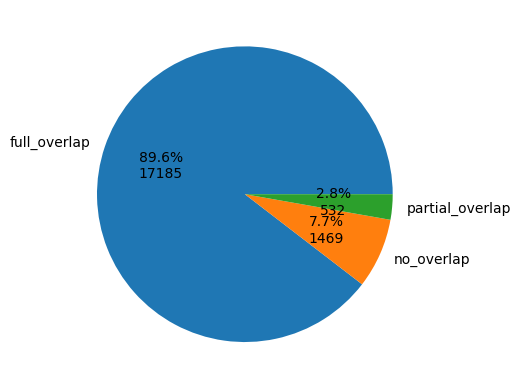

2024-03-01 17:32:15,445 - result_analysis.result_analysis - INFO - No filter_by_rt_overlap is specified, use all entries for plotting.
2024-03-01 17:32:15,453 - result_analysis.result_analysis - INFO - Drop all duplicated pcm. 19186 -> 18753
2024-03-01 17:32:15,570 - postprocessing.peak_selection - INFO - Use RT range as reference for peak selection.


In [7]:
# match peaks to experiment
from result_analysis import result_analysis
from postprocessing.peak_selection import match_peaks_to_exp

if peak_results_search_range_pred_score.matched.isna().sum() > 0:
    sum_peak = pd.read_csv(os.path.join(result_dir, "sum_peak.csv"))
    sbs_result = result_analysis.SBSResult(
        maxquant_ref_df=maxquant_result_ref,
        maxquant_exp_df=maxquant_result_exp,
        sum_peak=sum_peak,
    )

    sbs_result.compare_with_maxquant_exp_int(
        filter_by_rt_overlap=None, handle_mul_exp_pcm="drop", save_dir=None
    )
    merged_df = sbs_result.ref_exp_df_inner
    peak_results_search_range_pred_score_matched = match_peaks_to_exp(
        ref_exp_inner_df=merged_df, peak_results=peak_results_search_range_pred_score
    )

In [38]:
sbs_result.plot_intensity_corr(
    inf_col="AUCActivationPeak", interactive=True, hover_data=["id"]
)

Data:  Intensity_log AUCActivationPeak_log , slope =  0.487 , intercept =  1.964 , PearsonR =  0.333 , SpearmanR =  0.362


## Peak sequence classification

In [15]:
pred_df_all0 = pred_df.copy()
pred_df_all0["y_pred_prob"] = 0

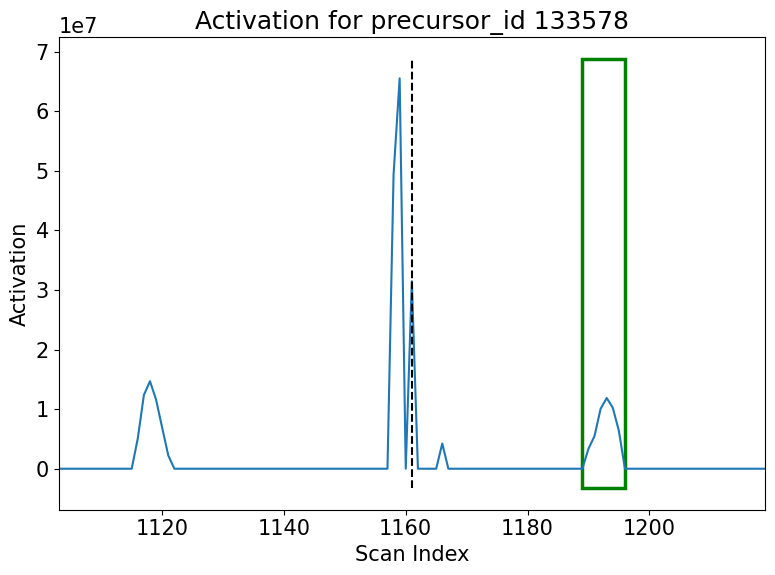

In [47]:
%autoreload 2
from postprocessing.peak_selection import plot_activation_and_score
import matplotlib.pyplot as plt
plt.rc("font", size=15)
plot_activation_and_score(
    peak_results=peak_results_search_range_pred_score_matched,
    df_test=pred_df_all0,
    activation=activation_df,
    precursor_id=133578,
    log_int=False,
    show_pred_peak = False
)

In [30]:
maxquant_result_ref.loc[
    [88, 61750, 169058], ["predicted_RT", "Calibrated retention time"]
]

predicted_RT  Calibrated retention time
id                                             
88          6.642127                     6.6515
61750       8.281170                     8.0374
169058      6.842224                     6.3340

ValueError: Axis limits cannot be NaN or Inf

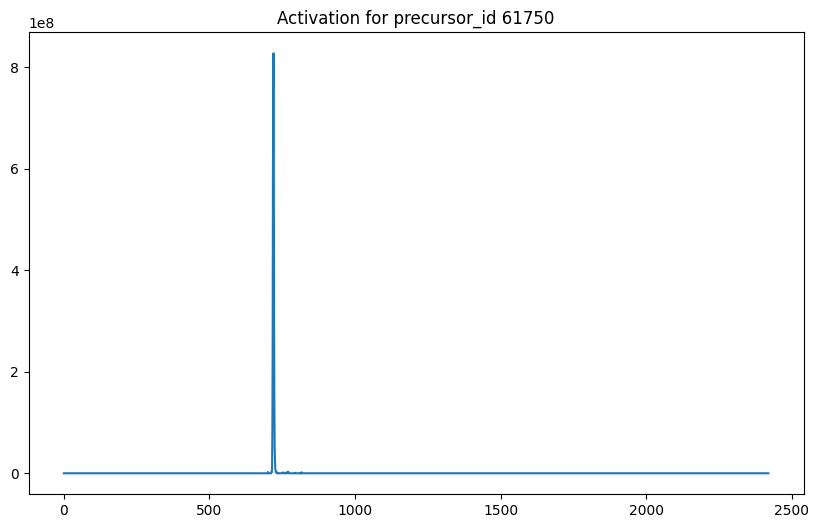

In [26]:
plot_activation_and_score(
    peak_results=peak_results_matched_search_range,
    df_test=pred_df,
    activation=activation_df,
    precursor_id=61750,
)

In [42]:
maxquant_result_ref.loc[
    maxquant_result_ref.id.isin([783, 39773, 125150]),
    [
        "Modified sequence",
        "Calibrated retention time",
        "IsoMZ",
        "IsoAbundance",
        "RT_search_left",
        "RT_search_center",
        "RT_search_right",
    ],
]

Modified sequence  Calibrated retention time  \
id                                                    
783       _AAHEVLMEMGEK_                    10.3920   
39773       _EKWHYDPELK_                     8.8691   
125150     _MNNFNLHTPTR_                     9.8448   

                                                    IsoMZ  \
id                                                          
783     [448.88161109763996, 449.2139560627067, 449.21...   
39773   [448.8914920651467, 449.22383703021336, 449.22...   
125150  [448.88797625538, 449.2203212204467, 449.22242...   

                                             IsoAbundance  RT_search_left  \
id                                                                          
783     [0.43936447626601244, 0.024090121199335394, 0....        9.612863   
39773   [0.45268802867584046, 0.0248206445112932, 0.31...        8.050839   
125150  [0.4533538139294238, 0.03148572227392088, 0.28...        9.148653   

        RT_search_center  RT_search_right  
id                                         
783            10.612863        11.612863  
39773           9.050839        10.050839  
125150         10.148653        11.148653

In [70]:
maxquant_result_ref.loc[maxquant_result_ref.id.isin([783]), ["IsoMZ"]].values[0][0],
maxquant_result_ref.lsoc[maxquant_result_ref.id.isin([125150]), ["IsoMZ"]].values[0][0]

(array([448.8816111 , 449.21395606, 449.21606271, 449.54687638,
        449.54840767, 449.54969276, 449.55051432, 449.88132799,
        449.88414437]),)

array([448.88797626, 449.22032122, 449.22242787, 449.55324154,
       449.55477283, 449.55605792, 449.55687948, 449.88769315,
       449.89133109])

In [71]:
from scipy.spatial.distance import cdist

res = cdist(
    [
        maxquant_result_ref.loc[maxquant_result_ref.id.isin([783]), ["IsoMZ"]].values[
            0
        ][0][:9],
        maxquant_result_ref.loc[
            maxquant_result_ref.id.isin([783]), ["IsoAbundance"]
        ].values[0][0][:9],
    ],
    [
        maxquant_result_ref.loc[
            maxquant_result_ref.id.isin([125150]), ["IsoMZ"]
        ].values[0][0],
        maxquant_result_ref.loc[
            maxquant_result_ref.id.isin([125150]), ["IsoAbundance"]
        ].values[0][0],
    ],
    metric="cosine",
)

In [72]:
res[0, 0] * res[1, 1]

1.925534948100395e-16

In [7]:
from scipy.stats import wasserstein_distance

wasserstein_distance(
    maxquant_result_ref.loc[
        maxquant_result_ref.id.isin([783]), ["IsoAbundance"]
    ].values[0][0],
    maxquant_result_ref.loc[
        maxquant_result_ref.id.isin([125150]), ["IsoAbundance"]
    ].values[0][0],
    maxquant_result_ref.loc[maxquant_result_ref.id.isin([783]), [
        "IsoMZ"]].values[0][0],
    maxquant_result_ref.loc[maxquant_result_ref.id.isin([125150]), ["IsoMZ"]].values[0][
        0
    ],
)

0.013193275852224316

# Handle collinearity in precursors

1. Compile a list of collinear precursors that also have overlapping search window
2. Remove these precursors from Quant corr plot --> see result
3. Process the precursors on the list one by one

In [39]:
peak_results_matched = pd.read_csv(os.path.join(result_dir, "peak_results_matched.csv"))
matched_precursor_id = peak_results_matched.id.nunique()